In [16]:
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import RobertaConfig, RobertaModel, AutoTokenizer, AutoModel, RobertaTokenizerFast
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Choose Model

In [2]:
config = 'roberta'
model_type = 'roberta' #GPT or roberta
mode = 'test' #val or test

In [3]:
if config == 'random_init':
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
    configuration = RobertaConfig()
    base_model = RobertaModel(configuration)
    
elif config == 'roberta':
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
    configuration = RobertaConfig()
    base_model = RobertaModel(configuration)
    configuration = base_model.config

elif config == 'ChemBERTa_pubchem':
    tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTA_PubChem1M_shard00_155k")
    base_model = AutoModel.from_pretrained("seyonec/ChemBERTA_PubChem1M_shard00_155k")
    
elif config == 'ChemBERTa_10M':
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MTR")
    base_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-10M-MTR")

elif config == 'ChemGPT':
    tokenizer = AutoTokenizer.from_pretrained("ncfrey/ChemGPT-1.2B")
    base_model = AutoModel.from_pretrained("ncfrey/ChemGPT-1.2B")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
num_params = 0
for params in base_model.parameters():
    num_params+=params.numel()
print('Total number of parameters in selected model (without head):',num_params)

Total number of parameters in selected model (without head): 124644864


In [5]:
class FullModel(nn.Module):
    def __init__(self, base_model, model_type, num_outputs):
        super(FullModel, self).__init__()
        self.model_type = model_type
        self.base = base_model
        
        self.lin1 = nn.Linear(base_model.config.hidden_size, 512)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(512, num_outputs)

    def forward(self, input_ids, attention_mask):
        # Pass the input through base model
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)

        # Apply the linear layer for classification
        if model_type == 'roberta':
            x = self.relu(self.lin1(outputs['pooler_output']))
        elif model_type =='GPT':
            x = self.relu(self.lin1(outputs['last_hidden_state'][:,-1,:]))
        x = self.lin2(x)

        return x

In [6]:
model = FullModel(base_model, model_type, num_outputs = 4)

torch.cuda.set_device(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FullModel(
  (base): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

## Loading Data and Preprocessing

In [7]:
df = pd.read_csv('parkinsons.csv')
selected_columns = ['Molecular Weight', '#RO5 Violations','Smiles', 'AlogP', 'pChEMBL Value']
columns_to_check = ['Molecular Weight', '#RO5 Violations', 'AlogP', 'pChEMBL Value']
for col in columns_to_check:
    df = df[pd.to_numeric(df[col], errors='coerce').notnull()]
df_selected = df[selected_columns].dropna()
# df_selected

In [8]:
test_size = 0.2
val_size = 0.5

train_df, test_df = train_test_split(df_selected, test_size=test_size, random_state=42)
test_df, val_df = train_test_split(test_df, test_size=val_size, random_state=42)

In [9]:
class smiles_dataset(Dataset):
 
    def __init__(self,df):
        if tokenizer.pad_token is None:
            print("no padding defined in tokenizer, using [PAD] token by default")
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.encodings = tokenizer(df["Smiles"].tolist(), return_tensors="pt",truncation=True, padding=True)
        data = df[['Molecular Weight', '#RO5 Violations', 'AlogP','pChEMBL Value']].values.astype(float)
        
        self.y = torch.tensor(data, dtype=torch.float32)
        mean = self.y.mean(dim=0)
        std = self.y.std(dim=0)
        self.y = (self.y - mean) / std
    
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        input_ids = self.encodings['input_ids'][idx]
        attention_mask = self.encodings['attention_mask'][idx]
        return (input_ids, attention_mask),self.y[idx]

In [10]:
train_data = smiles_dataset(train_df)
test_data = smiles_dataset(test_df)
val_data = smiles_dataset(val_df)

batch_size = 32

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
if mode=='val':
    eval_dataloader = DataLoader(val_data, batch_size = batch_size)
elif mode=='test':
    eval_dataloader = DataLoader(test_data, batch_size = batch_size)

## Train

In [11]:
learning_rate = 5e-8
num_epochs = 150
weight_decay=1e-9
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [12]:
train_f1_list = []
test_f1_list = []
loss_train = []
loss_test=[]

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for n, ((input_ids,attention_mask),targets) in enumerate(tqdm(train_dataloader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)
        
        outputs = model(input_ids = input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}")
    loss_train.append(train_loss)
    
    model.eval()
    total_loss = 0
    for n, ((input_id,attention_mask),labels) in enumerate(eval_dataloader):
        input_id = input_id.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_id, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    
    eval_loss = total_loss / len(eval_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Eval Loss: {eval_loss}")
    loss_test.append(eval_loss)

100%|█████████████████████████████████████████| 295/295 [00:45<00:00,  6.42it/s]


Epoch 1/150, Train Loss: 0.9971062323804629
Epoch 1/150, Eval Loss: 0.981082974253474


100%|█████████████████████████████████████████| 295/295 [00:45<00:00,  6.47it/s]


Epoch 2/150, Train Loss: 0.9735932327933231
Epoch 2/150, Eval Loss: 0.9447470565099974


100%|█████████████████████████████████████████| 295/295 [00:45<00:00,  6.43it/s]


Epoch 3/150, Train Loss: 0.9362405203156552
Epoch 3/150, Eval Loss: 0.8786225447783599


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.39it/s]


Epoch 4/150, Train Loss: 0.8842532545833265
Epoch 4/150, Eval Loss: 0.8422240969297048


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.37it/s]


Epoch 5/150, Train Loss: 0.8246259822683819
Epoch 5/150, Eval Loss: 0.7167558396184767


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.33it/s]


Epoch 6/150, Train Loss: 0.7941905323731697
Epoch 6/150, Eval Loss: 0.68260426376317


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.32it/s]


Epoch 7/150, Train Loss: 0.8420006419642497
Epoch 7/150, Eval Loss: 0.7939605680671898


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.31it/s]


Epoch 8/150, Train Loss: 0.7881689165608358
Epoch 8/150, Eval Loss: 0.7129131080331029


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 9/150, Train Loss: 0.8135918774847257
Epoch 9/150, Eval Loss: 0.6980595218168723


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 10/150, Train Loss: 0.8133617402133295
Epoch 10/150, Eval Loss: 0.6742309855448233


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.26it/s]


Epoch 11/150, Train Loss: 0.7888339594259101
Epoch 11/150, Eval Loss: 0.8051041268013619


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 12/150, Train Loss: 0.7276861037238169
Epoch 12/150, Eval Loss: 0.7572403453491829


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.26it/s]


Epoch 13/150, Train Loss: 0.7523281319666717
Epoch 13/150, Eval Loss: 0.639332917896477


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 14/150, Train Loss: 0.7144000599950047
Epoch 14/150, Eval Loss: 0.7145500964409596


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 15/150, Train Loss: 0.6875731375257847
Epoch 15/150, Eval Loss: 0.673502070678247


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 16/150, Train Loss: 0.6719984924389144
Epoch 16/150, Eval Loss: 0.6365576209248723


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 17/150, Train Loss: 0.6591869350207054
Epoch 17/150, Eval Loss: 0.5941091373160079


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 18/150, Train Loss: 0.6403968461489273
Epoch 18/150, Eval Loss: 0.6554667941621832


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 19/150, Train Loss: 0.604421337479252
Epoch 19/150, Eval Loss: 0.5567252144620225


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 20/150, Train Loss: 0.6020478578947358
Epoch 20/150, Eval Loss: 0.5619703716522938


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 21/150, Train Loss: 0.5785969836226964
Epoch 21/150, Eval Loss: 0.5105863173265714


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 22/150, Train Loss: 0.5659035218974291
Epoch 22/150, Eval Loss: 0.5555308807540584


100%|█████████████████████████████████████████| 295/295 [00:50<00:00,  5.80it/s]


Epoch 23/150, Train Loss: 0.5695086412510629
Epoch 23/150, Eval Loss: 0.5282840648212949


100%|█████████████████████████████████████████| 295/295 [01:07<00:00,  4.34it/s]


Epoch 24/150, Train Loss: 0.5407253348221213
Epoch 24/150, Eval Loss: 0.537167671564463


100%|█████████████████████████████████████████| 295/295 [01:10<00:00,  4.17it/s]


Epoch 25/150, Train Loss: 0.5468787525670004
Epoch 25/150, Eval Loss: 0.5231715102453489


100%|█████████████████████████████████████████| 295/295 [01:07<00:00,  4.37it/s]


Epoch 26/150, Train Loss: 0.5433211762016102
Epoch 26/150, Eval Loss: 0.5318301601989849


100%|█████████████████████████████████████████| 295/295 [00:49<00:00,  5.99it/s]


Epoch 27/150, Train Loss: 0.5246278916375112
Epoch 27/150, Eval Loss: 0.5186881334395022


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.16it/s]


Epoch 28/150, Train Loss: 0.5344295970464157
Epoch 28/150, Eval Loss: 0.5504989688460892


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.19it/s]


Epoch 29/150, Train Loss: 0.5271798037876517
Epoch 29/150, Eval Loss: 0.4967000814708504


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.21it/s]


Epoch 30/150, Train Loss: 0.5064515506311998
Epoch 30/150, Eval Loss: 0.4888257819253045


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.23it/s]


Epoch 31/150, Train Loss: 0.5108006445028014
Epoch 31/150, Eval Loss: 0.4616164597305092


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 32/150, Train Loss: 0.5099029163182792
Epoch 32/150, Eval Loss: 0.4458318481574187


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 33/150, Train Loss: 0.5034336084026402
Epoch 33/150, Eval Loss: 0.4784147288348224


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 34/150, Train Loss: 0.4941035857645132
Epoch 34/150, Eval Loss: 0.49388583930763036


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 35/150, Train Loss: 0.48247543391534836
Epoch 35/150, Eval Loss: 0.4628101007358448


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 36/150, Train Loss: 0.49126127180406604
Epoch 36/150, Eval Loss: 0.4339202650495478


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 37/150, Train Loss: 0.486945702514406
Epoch 37/150, Eval Loss: 0.4589002881501172


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 38/150, Train Loss: 0.4698857712543617
Epoch 38/150, Eval Loss: 0.4823079358887028


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 39/150, Train Loss: 0.48123717030226176
Epoch 39/150, Eval Loss: 0.4360173449322984


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 40/150, Train Loss: 0.48111151704343696
Epoch 40/150, Eval Loss: 0.45628505623018417


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.26it/s]


Epoch 41/150, Train Loss: 0.4628172858286712
Epoch 41/150, Eval Loss: 0.4700070973989126


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 42/150, Train Loss: 0.46623067234532306
Epoch 42/150, Eval Loss: 0.42792420572525747


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 43/150, Train Loss: 0.4710076792765472
Epoch 43/150, Eval Loss: 0.45203005059345347


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 44/150, Train Loss: 0.4487363076816171
Epoch 44/150, Eval Loss: 0.4389485314085677


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 45/150, Train Loss: 0.454833968514103
Epoch 45/150, Eval Loss: 0.41491727571229675


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]


Epoch 46/150, Train Loss: 0.4499323792376761
Epoch 46/150, Eval Loss: 0.4280179589986801


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.26it/s]


Epoch 47/150, Train Loss: 0.43690248652029845
Epoch 47/150, Eval Loss: 0.43039880652685425


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 48/150, Train Loss: 0.4402685347249952
Epoch 48/150, Eval Loss: 0.41032562304187464


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.26it/s]


Epoch 49/150, Train Loss: 0.4342175312466541
Epoch 49/150, Eval Loss: 0.40717100130545125


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.24it/s]


Epoch 50/150, Train Loss: 0.43335343594268216
Epoch 50/150, Eval Loss: 0.41742643875044744


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 51/150, Train Loss: 0.4226138850389901
Epoch 51/150, Eval Loss: 0.4145627964187313


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 52/150, Train Loss: 0.4247738712419898
Epoch 52/150, Eval Loss: 0.39746025849033045


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.25it/s]


Epoch 53/150, Train Loss: 0.4253792603137129
Epoch 53/150, Eval Loss: 0.39792275750959244


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.22it/s]


Epoch 54/150, Train Loss: 0.4164481063010329
Epoch 54/150, Eval Loss: 0.4106445014476776


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 55/150, Train Loss: 0.41680979935799617
Epoch 55/150, Eval Loss: 0.39955610922864965


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]


Epoch 56/150, Train Loss: 0.41263246031130774
Epoch 56/150, Eval Loss: 0.39922654789847295


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.28it/s]


Epoch 57/150, Train Loss: 0.4155592349121126
Epoch 57/150, Eval Loss: 0.38655326334205836


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]


Epoch 58/150, Train Loss: 0.4081644857333878
Epoch 58/150, Eval Loss: 0.3947377559301016


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]


Epoch 59/150, Train Loss: 0.40565558975025756
Epoch 59/150, Eval Loss: 0.39721693783193024


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 60/150, Train Loss: 0.4044032097367917
Epoch 60/150, Eval Loss: 0.38420430470157313


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 61/150, Train Loss: 0.40214691914744294
Epoch 61/150, Eval Loss: 0.3834339911873276


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 62/150, Train Loss: 0.39739559883788483
Epoch 62/150, Eval Loss: 0.3819367378144651


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 63/150, Train Loss: 0.3956908186613503
Epoch 63/150, Eval Loss: 0.3836075675648612


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 64/150, Train Loss: 0.3923356038028911
Epoch 64/150, Eval Loss: 0.38306487089878805


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 65/150, Train Loss: 0.3928845302028171
Epoch 65/150, Eval Loss: 0.37609764208664764


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 66/150, Train Loss: 0.38984768744242393
Epoch 66/150, Eval Loss: 0.37165958253113


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 67/150, Train Loss: 0.38926454090465934
Epoch 67/150, Eval Loss: 0.38098338890720057


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]


Epoch 68/150, Train Loss: 0.38478893900321703
Epoch 68/150, Eval Loss: 0.37282698621621


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.27it/s]


Epoch 69/150, Train Loss: 0.38447244995731417
Epoch 69/150, Eval Loss: 0.3792884112209887


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 70/150, Train Loss: 0.38110795985844176
Epoch 70/150, Eval Loss: 0.36715536181991165


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 71/150, Train Loss: 0.38107556766372613
Epoch 71/150, Eval Loss: 0.36604274205259374


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 72/150, Train Loss: 0.37912872115434226
Epoch 72/150, Eval Loss: 0.36976275089624766


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 73/150, Train Loss: 0.37815114992149806
Epoch 73/150, Eval Loss: 0.365116037227012


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 74/150, Train Loss: 0.37325322511842696
Epoch 74/150, Eval Loss: 0.3745287608455967


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 75/150, Train Loss: 0.3723037600517273
Epoch 75/150, Eval Loss: 0.35888593422399984


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 76/150, Train Loss: 0.3697582899513891
Epoch 76/150, Eval Loss: 0.3624650195643708


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 77/150, Train Loss: 0.369361289325407
Epoch 77/150, Eval Loss: 0.3584013492674441


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 78/150, Train Loss: 0.3657521188764249
Epoch 78/150, Eval Loss: 0.35402812627521724


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 79/150, Train Loss: 0.3654380682161299
Epoch 79/150, Eval Loss: 0.36354518742174713


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 80/150, Train Loss: 0.36203671400829895
Epoch 80/150, Eval Loss: 0.35353072350089615


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 81/150, Train Loss: 0.360155273140487
Epoch 81/150, Eval Loss: 0.3640738910919911


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 82/150, Train Loss: 0.3602993310002957
Epoch 82/150, Eval Loss: 0.35026733214790756


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 83/150, Train Loss: 0.35871272774065954
Epoch 83/150, Eval Loss: 0.3559091324741776


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 84/150, Train Loss: 0.3574421330528744
Epoch 84/150, Eval Loss: 0.35151968372834697


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 85/150, Train Loss: 0.35506583442122247
Epoch 85/150, Eval Loss: 0.3495656827817092


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.28it/s]


Epoch 86/150, Train Loss: 0.35476047270378824
Epoch 86/150, Eval Loss: 0.3456455525514242


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 87/150, Train Loss: 0.35460310244964344
Epoch 87/150, Eval Loss: 0.341859020494126


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 88/150, Train Loss: 0.35055304098937473
Epoch 88/150, Eval Loss: 0.34608969132642486


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 89/150, Train Loss: 0.3489537280494884
Epoch 89/150, Eval Loss: 0.34346448811324864


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 90/150, Train Loss: 0.34693023092665914
Epoch 90/150, Eval Loss: 0.35004938172327504


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.31it/s]


Epoch 91/150, Train Loss: 0.34685287712994267
Epoch 91/150, Eval Loss: 0.3388115707281473


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 92/150, Train Loss: 0.3449419611591404
Epoch 92/150, Eval Loss: 0.34741446013386185


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 93/150, Train Loss: 0.34111680317733245
Epoch 93/150, Eval Loss: 0.33568643557058797


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 94/150, Train Loss: 0.3416271079394777
Epoch 94/150, Eval Loss: 0.3492971280136624


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 95/150, Train Loss: 0.3390901007894742
Epoch 95/150, Eval Loss: 0.33499649086514033


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 96/150, Train Loss: 0.3398826965841196
Epoch 96/150, Eval Loss: 0.3448298569466617


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 97/150, Train Loss: 0.3376217982526553
Epoch 97/150, Eval Loss: 0.3300573112996849


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 98/150, Train Loss: 0.33701195560269437
Epoch 98/150, Eval Loss: 0.3380092261610804


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 99/150, Train Loss: 0.3388319789858188
Epoch 99/150, Eval Loss: 0.3338563458339588


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 100/150, Train Loss: 0.3344874190577006
Epoch 100/150, Eval Loss: 0.34193708163660924


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 101/150, Train Loss: 0.3322782614473569
Epoch 101/150, Eval Loss: 0.33737812372478276


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 102/150, Train Loss: 0.33317214679920065
Epoch 102/150, Eval Loss: 0.33435849201034856


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 103/150, Train Loss: 0.3329801728159694
Epoch 103/150, Eval Loss: 0.3241728669082796


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 104/150, Train Loss: 0.3327188059435052
Epoch 104/150, Eval Loss: 0.32818567752838135


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 105/150, Train Loss: 0.3305716316578752
Epoch 105/150, Eval Loss: 0.3278839423044308


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 106/150, Train Loss: 0.32832213761442797
Epoch 106/150, Eval Loss: 0.3349435615378457


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 107/150, Train Loss: 0.32759987120911227
Epoch 107/150, Eval Loss: 0.3352684886068911


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 108/150, Train Loss: 0.32994302107115925
Epoch 108/150, Eval Loss: 0.3225454180627256


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 109/150, Train Loss: 0.3327580236782462
Epoch 109/150, Eval Loss: 0.33615198046774475


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 110/150, Train Loss: 0.33083796486005945
Epoch 110/150, Eval Loss: 0.32416552587135417


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 111/150, Train Loss: 0.32505534250857465
Epoch 111/150, Eval Loss: 0.3425333600591969


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 112/150, Train Loss: 0.32852614698773724
Epoch 112/150, Eval Loss: 0.32077279686927795


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 113/150, Train Loss: 0.3280924934451863
Epoch 113/150, Eval Loss: 0.32344744294076355


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 114/150, Train Loss: 0.3313767697851537
Epoch 114/150, Eval Loss: 0.316035634762532


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 115/150, Train Loss: 0.3294580364631394
Epoch 115/150, Eval Loss: 0.33340014477033875


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 116/150, Train Loss: 0.32237457976502887
Epoch 116/150, Eval Loss: 0.33424075310294693


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 117/150, Train Loss: 0.32471669245574436
Epoch 117/150, Eval Loss: 0.3211828482312125


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 118/150, Train Loss: 0.32560125013529245
Epoch 118/150, Eval Loss: 0.30909016084026647


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 119/150, Train Loss: 0.3262045964851218
Epoch 119/150, Eval Loss: 0.32966065849806814


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 120/150, Train Loss: 0.32061798340183195
Epoch 120/150, Eval Loss: 0.327358640529014


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 121/150, Train Loss: 0.3194463917764567
Epoch 121/150, Eval Loss: 0.32155675662530436


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 122/150, Train Loss: 0.3269779728125718
Epoch 122/150, Eval Loss: 0.3072545101513734


100%|█████████████████████████████████████████| 295/295 [00:47<00:00,  6.28it/s]


Epoch 123/150, Train Loss: 0.3226263932757458
Epoch 123/150, Eval Loss: 0.3252164657051499


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 124/150, Train Loss: 0.3178619737847377
Epoch 124/150, Eval Loss: 0.32833478056095744


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 125/150, Train Loss: 0.31924453564619615
Epoch 125/150, Eval Loss: 0.31155549030046203


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 126/150, Train Loss: 0.3222826510667801
Epoch 126/150, Eval Loss: 0.30472644438614716


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 127/150, Train Loss: 0.3178989436666844
Epoch 127/150, Eval Loss: 0.327970569198196


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 128/150, Train Loss: 0.31434660761033073
Epoch 128/150, Eval Loss: 0.31178961210959666


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 129/150, Train Loss: 0.31890075545189744
Epoch 129/150, Eval Loss: 0.3084042209225732


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 130/150, Train Loss: 0.31971517311314407
Epoch 130/150, Eval Loss: 0.31218000078523483


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 131/150, Train Loss: 0.31297372594728307
Epoch 131/150, Eval Loss: 0.32149664493831426


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 132/150, Train Loss: 0.3151408739009146
Epoch 132/150, Eval Loss: 0.30587426915362076


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 133/150, Train Loss: 0.3167334697004092
Epoch 133/150, Eval Loss: 0.30750220208554657


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 134/150, Train Loss: 0.311826593037379
Epoch 134/150, Eval Loss: 0.31007486259615097


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 135/150, Train Loss: 0.3092238968206664
Epoch 135/150, Eval Loss: 0.31610857514110774


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 136/150, Train Loss: 0.3136059681237754
Epoch 136/150, Eval Loss: 0.29575822200324087


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 137/150, Train Loss: 0.3134721637782404
Epoch 137/150, Eval Loss: 0.31500984808883153


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 138/150, Train Loss: 0.3067955414622517
Epoch 138/150, Eval Loss: 0.31134215601392695


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 139/150, Train Loss: 0.3070023005291567
Epoch 139/150, Eval Loss: 0.30693178362137563


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 140/150, Train Loss: 0.31004807797528927
Epoch 140/150, Eval Loss: 0.29828773237563466


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 141/150, Train Loss: 0.30571416970026694
Epoch 141/150, Eval Loss: 0.31799735410793406


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 142/150, Train Loss: 0.3029769937870866
Epoch 142/150, Eval Loss: 0.2978807446118948


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 143/150, Train Loss: 0.30801129649251197
Epoch 143/150, Eval Loss: 0.30813523925639486


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.30it/s]


Epoch 144/150, Train Loss: 0.3059901303153927
Epoch 144/150, Eval Loss: 0.308227609138231


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 145/150, Train Loss: 0.3028411318184966
Epoch 145/150, Eval Loss: 0.31523837632424123


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 146/150, Train Loss: 0.3059129535646762
Epoch 146/150, Eval Loss: 0.28970992323514577


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.28it/s]


Epoch 147/150, Train Loss: 0.30435633805848783
Epoch 147/150, Eval Loss: 0.3106564891499442


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 148/150, Train Loss: 0.29901453574835246
Epoch 148/150, Eval Loss: 0.30035340262425914


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 149/150, Train Loss: 0.3027103348303649
Epoch 149/150, Eval Loss: 0.30109500562822494


100%|█████████████████████████████████████████| 295/295 [00:46<00:00,  6.29it/s]


Epoch 150/150, Train Loss: 0.30282947794865755
Epoch 150/150, Eval Loss: 0.29409870263692495


## Plot results

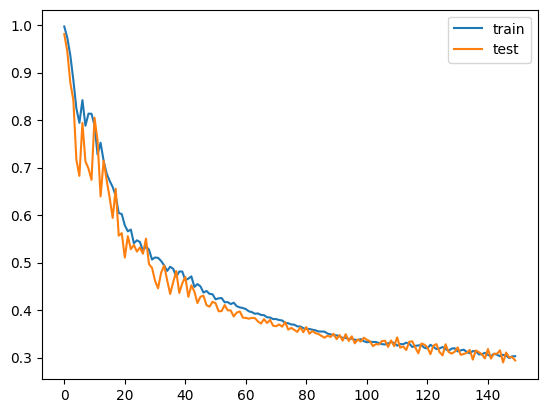

In [14]:
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.legend()

In [17]:
num_variables = 4

model.eval()  # Set the model to evaluation mode
total_mae_per_variable = [0.0] * num_variables
total_samples = 0

with torch.no_grad():
    for (input_ids, attention_mask), targets in eval_dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        targets = targets.to(device)
        predictions = model(input_ids = input_ids, attention_mask=attention_mask)

        for i in range(num_variables):
            mae_per_batch = F.l1_loss(predictions[:, i], targets[:, i], reduction='sum').item()
            total_mae_per_variable[i] += mae_per_batch

        total_samples += len(targets)

mean_absolute_error_per_variable = [mae / total_samples for mae in total_mae_per_variable]
mean_absolute_error_per_variable

[0.1568813481975027,
 0.25830268292682296,
 0.289043309431311,
 0.6872586839363144]

In [18]:
y = df_selected[['Molecular Weight', '#RO5 Violations', 'AlogP','pChEMBL Value']].values.astype(float)
y = torch.tensor(y, dtype=torch.float32)
mean = y.mean(dim=0)
std = y.std(dim=0)
MAE = torch.tensor(mean_absolute_error_per_variable)*std
MAE

tensor([15.9689,  0.1524,  0.3720,  0.7747])